# Step-1: Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

# Standard library
from pathlib import Path
import pprint

# Third-party libraries
import duckdb
import fireducks.pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optuna
from matplotlib import rcParams
from sklearn.covariance import EmpiricalCovariance

rcParams["text.usetex"] = True

# Custom osbad library for anomaly detection
import osbad.config as bconf
import osbad.hyperparam as hp
import osbad.modval as modval
import osbad.viz as bviz
from osbad.database import BenchDB
from osbad.model import ModelRunner

# Step-2: Load Tohoku Benchmarking Dataset

In [2]:
# Path to database directory
DB_DIR = bconf.DB_DIR
db_filepath = DB_DIR.joinpath("tohoku_benchmark_dataset.db")

# Create a DuckDB connection
con = duckdb.connect(
    db_filepath,
    read_only=True)

# Load all training dataset from duckdb
df_duckdb = con.execute(
    "SELECT * FROM df_tohoku_dataset").fetchdf()

# Drop the additional index column
df_duckdb = df_duckdb.drop(
    columns="__index_level_0__",
    errors="ignore")

unique_cell_index_train = df_duckdb["cell_index"].unique()
print(unique_cell_index_train)

# Get the cell-ID from cell_inventory
selected_cell_label = "cell_num_1"
cell_num = selected_cell_label[-1]

# Create a subfolder to store fig output
# corresponding to each cell-index
selected_cell_artifacts_dir = bconf.artifacts_output_dir(
    selected_cell_label)

# Filter dataset for specific selected cell only
df_selected_cell = df_duckdb[
    df_duckdb["cell_index"] == selected_cell_label]

# Import the BenchDB class
benchdb = BenchDB(
    db_filepath,
    selected_cell_label)

# Drop the outlier labels
df_selected_cell_without_labels = df_selected_cell.drop(
    "outlier", axis=1).reset_index(drop=True)

['cell_num_1' 'cell_num_2' 'cell_num_3' 'cell_num_4' 'cell_num_5'
 'cell_num_6' 'cell_num_7' 'cell_num_8' 'cell_num_9' 'cell_num_10']


# Step-3: Plot Capacity Fade Without Labels

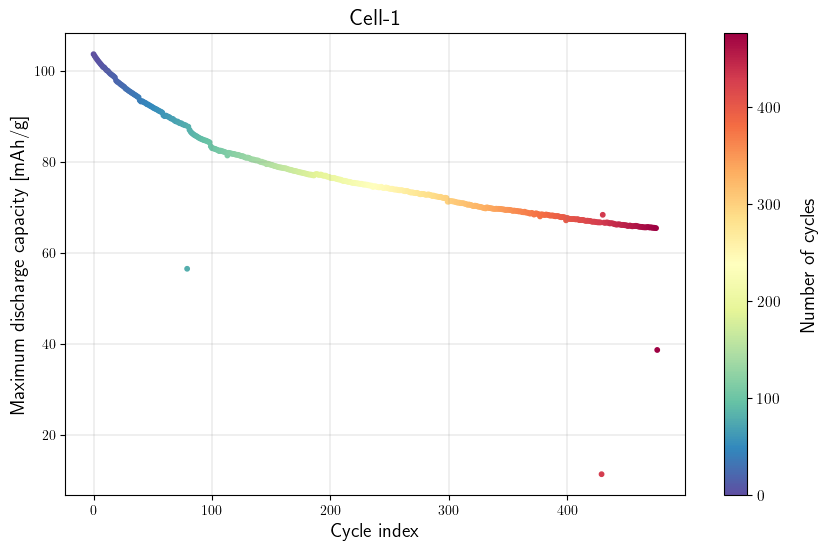

In [3]:
# Calculate maximum capacity per cycle
max_cap_per_cycle = (
    df_selected_cell_without_labels
        .groupby(["cycle_index"])["discharge_capacity"].max())
max_cap_per_cycle.name = "max_discharge_capacity"

unique_cycle_index = (
    df_selected_cell_without_labels["cycle_index"].unique())

# Plot the cycling data without labels
axplot = bviz.plot_cycle_data(
    xseries=unique_cycle_index,
    yseries=max_cap_per_cycle,
    cycle_index_series=unique_cycle_index)

axplot.set_xlabel(
    r"Cycle index",
    fontsize=14)
axplot.set_ylabel(
    r"Maximum discharge capacity [mAh/g]",
    fontsize=14)

axplot.set_title(
    f"Cell-{cell_num}",
    fontsize=16)

output_fig_filename = (
    "cycling_data_without_labels_"
    + selected_cell_label
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")


# Step-4: Feature Engineering with Mahalanobis Distance

In [4]:
df_cycle_index = pd.Series(
    unique_cycle_index,
    name="cycle_index")

# Input features for Mahalanobis distance
df_features_per_cell = pd.concat(
    [df_cycle_index,
     max_cap_per_cycle],
    axis=1)

Xfeat = df_features_per_cell.values

# Calculate Mahalanobis distance based on cycle_index and
# max_discharge_capacity
cov = EmpiricalCovariance().fit(Xfeat)
mahal_dist = cov.mahalanobis(Xfeat)

df_maha_dist = pd.Series(
    mahal_dist,
    name="mahal_dist")

# Merge calculated mahalanobis distance
df_merge_features = pd.concat(
    [df_features_per_cell,
     df_maha_dist], axis=1)

# Calculate maximum mahal_dist to normalize the distance calculation
max_mahal_dist = (
    df_merge_features["mahal_dist"].max())

df_merge_features["norm_mahal_dist"] = (
    df_merge_features["mahal_dist"]/max_mahal_dist)

selected_feature_cols = (
    "max_discharge_capacity",
    "norm_mahal_dist")

# Step-5: Hyperparameter Tuning with Optuna

* Define the search space for Isolation Forest hyperparameters:
    * contamination: Expected proportion of outliers (0.0 - 0.5)
    * n_estimators: Number of trees in the forest (100 - 500)
    * max_samples: Number of samples to train each tree
    * threshold: Decision threshold for outlier probability (0.0 - 1.0)
* Use Optuna’s TPE sampler to optimize for both precision and recall.
* Run 20 trials to find the best hyperparameter configuration.

In [5]:
total_cycle_count = len(df_selected_cell["cycle_index"].unique())

hp_config_iforest = {
    "contamination": {"low": 0.0, "high": 0.5},
    "n_estimators": {"low": 100, "high": 500},
    "max_samples": {"low": 100, "high": total_cycle_count},
    "threshold": {"low": 0.0, "high": 1.0}
}

iforest_hp_config_filepath = (
    Path.cwd()
    .parents[0]
    .joinpath(
        "machine_learning",
        "hp_config_schema",
        "tohoku_hp_config",
        "iforest_hp_config.json"))

bconf.create_json_hp_config(
    iforest_hp_config_filepath,
    hp_dict=hp_config_iforest)

# Reload the hp module to refresh in-memory variables
from importlib import reload
reload(hp)

# Instantiate an optuna study for iForest model
sampler = optuna.samplers.TPESampler(seed=42)

if_study = optuna.create_study(
    study_name="iforest_hyperparam",
    sampler=sampler,
    directions=["maximize","maximize"])

if_study.optimize(
    lambda trial: hp.objective(
        trial,
        model_id="iforest",
        df_feature_dataset=df_merge_features,
        selected_feature_cols=selected_feature_cols,
        df_benchmark_dataset=df_selected_cell,
        selected_cell_label=selected_cell_label),
    n_trials=20)

[I 2025-11-08 19:11:58,492] A new study created in memory with name: iforest_hyperparam
[I 2025-11-08 19:11:59,918] Trial 0 finished with values: [1.0, 0.75] and parameters: {'contamination': 0.18727005942368125, 'n_estimators': 481, 'max_samples': 376, 'threshold': 0.5986584841970366}.
[I 2025-11-08 19:12:00,601] Trial 1 finished with values: [0.6666666666666666, 1.0] and parameters: {'contamination': 0.07800932022121826, 'n_estimators': 162, 'max_samples': 121, 'threshold': 0.8661761457749352}.
[I 2025-11-08 19:12:01,629] Trial 2 finished with values: [0.3333333333333333, 1.0] and parameters: {'contamination': 0.3005575058716044, 'n_estimators': 383, 'max_samples': 107, 'threshold': 0.9699098521619943}.
[I 2025-11-08 19:12:02,369] Trial 3 finished with values: [1.0, 0.02912621359223301] and parameters: {'contamination': 0.41622132040021087, 'n_estimators': 185, 'max_samples': 168, 'threshold': 0.18340450985343382}.
[I 2025-11-08 19:12:03,389] Trial 4 finished with values: [1.0, 0.083

# Step-6: Aggregate Best Hyperparameters

* Extract the best trials from the Pareto front.
* Aggregate hyperparameters using median values to balance precision and recall.
* Export the optimized hyperparameters to CSV for reproducibility.

In [6]:
schema_iforest = {
    "threshold": "median",
    "contamination": "median",
    "n_estimators": "median_int",
    "max_samples": "median_int",
}

df_iforest_hyperparam = hp.aggregate_best_trials(
    if_study.best_trials,
    cell_label=selected_cell_label,
    model_id="iforest",
    schema=schema_iforest)

# Evaluate percentage of perfect recall and precision score
recall_score_pct, precision_score_pct = hp.evaluate_hp_perfect_score_pct(
    model_study=if_study)

Total trial count: 20
Trial 0:
Recall score per trial: 1.0
Precision score per trial: 0.75
----------------------------------------------------------------------
Trial 1:
Recall score per trial: 0.6666666666666666
Precision score per trial: 1.0
----------------------------------------------------------------------
Trial 2:
Recall score per trial: 0.3333333333333333
Precision score per trial: 1.0
----------------------------------------------------------------------
Trial 3:
Recall score per trial: 1.0
Precision score per trial: 0.02912621359223301
----------------------------------------------------------------------
Trial 4:
Recall score per trial: 1.0
Precision score per trial: 0.08333333333333333
----------------------------------------------------------------------
Trial 5:
Recall score per trial: 1.0
Precision score per trial: 0.12
----------------------------------------------------------------------
Trial 6:
Recall score per trial: 1.0
Precision score per trial: 0.27272727272727

/home/mei-chin-pang/02_academics/osbad_development/osbad/src/osbad/hyperparam.py:1265: ExperimentalWarning: optuna.visualization.matplotlib._pareto_front.plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  axplot = optuna.visualization.matplotlib.plot_pareto_front(


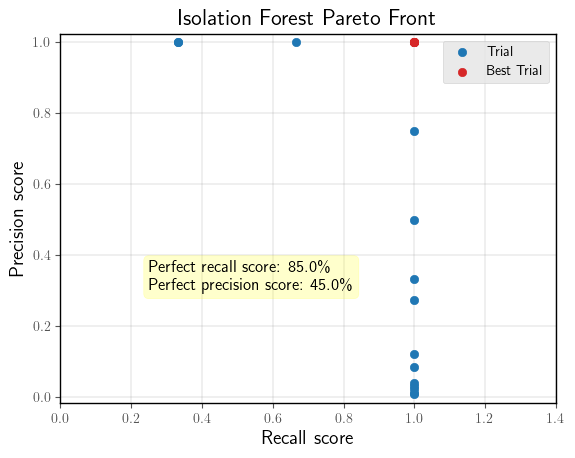

Have the hyperparam for cell_num_1 been evaluated?
True
**********************************************************************
Replacing existing rows for cell_num_1.
Hyperparameters for cell_num_1 have been replaced in the CSV file.


,ml_model,cell_index,threshold,contamination,n_estimators,max_samples
0,iforest,cell_num_1,0.732143,0.063146,321,445


In [7]:
# Plot pareto front
hp.plot_pareto_front(
    if_study,
    selected_cell_label,
    fig_title="Isolation Forest Pareto Front")

plt.show()

# Export current hyperparameters to CSV
hyperparam_filepath =  Path.cwd().joinpath(
    "hp_01_iforest_hyperparam_tohoku.csv")

hp.export_current_hyperparam(
    df_iforest_hyperparam,
    selected_cell_label,
    export_csv_filepath=hyperparam_filepath,
    if_exists="replace")

# Step-7: Train Model with Best Hyperparameters

* Load the optimized hyperparameters from the CSV file.
* Create a ModelRunner instance with the selected features.
* Train the Isolation Forest model using the best hyperparameters.
* Predict outlier probabilities and identify anomalous cycles

In [8]:
# Load best trial parameters from CSV output
df_hyperparam_from_csv = pd.read_csv(hyperparam_filepath)

df_param_per_cell = df_hyperparam_from_csv[
    df_hyperparam_from_csv["cell_index"] == selected_cell_label]

param_dict = df_param_per_cell.iloc[0].to_dict()
pprint.pp(param_dict)

# Run the model with best trial parameters
cfg = hp.MODEL_CONFIG["iforest"]

runner = ModelRunner(
    cell_label=selected_cell_label,
    df_input_features=df_merge_features,
    selected_feature_cols=selected_feature_cols
)

Xdata = runner.create_model_x_input()

model = cfg.model_param(param_dict)
print(model)
model.fit(Xdata)
proba = model.predict_proba(Xdata)

pred_outlier_indices, pred_outlier_score = runner.pred_outlier_indices_from_proba(
    proba=proba,
    threshold=param_dict["threshold"],
    outlier_col=cfg.proba_col
)

# Get df_outliers_pred
df_outliers_pred = (df_merge_features[
    df_merge_features["cycle_index"]
    .isin(pred_outlier_indices)].copy())

df_outliers_pred["outlier_prob"] = pred_outlier_score

{'ml_model': 'iforest',
 'cell_index': 'cell_num_1',
 'threshold': 0.7321432280768185,
 'contamination': 0.0631460561046617,
 'n_estimators': 321,
 'max_samples': 445}
IForest(behaviour='new', bootstrap=False, contamination=0.0631460561046617,
    max_features=1.0, max_samples=445, n_estimators=321, n_jobs=-1,
    random_state=42, verbose=0)


# Step-8: Predict Anomaly Score Map

* Generate a 2D contour map showing the anomaly probability across the feature space.
* Highlight the predicted anomalous cycles.
* The map helps visualize which regions of the feature space are considered anomalous by the model.


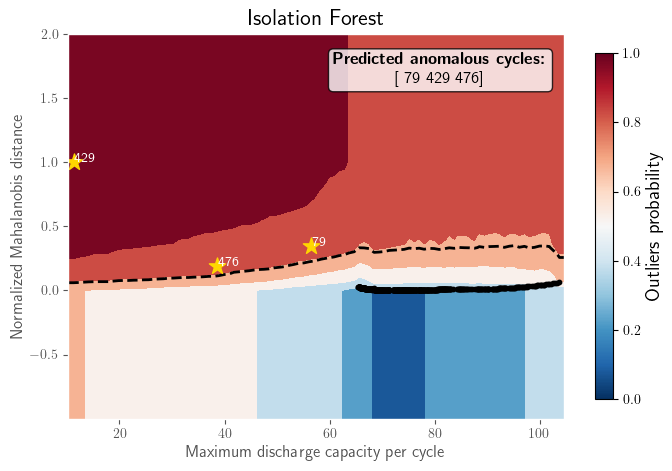

In [9]:
grid_offset_size = 1

axplot = runner.predict_anomaly_score_map(
    selected_model=model,
    model_name="Isolation Forest",
    xoutliers=df_outliers_pred["max_discharge_capacity"],
    youtliers=df_outliers_pred["norm_mahal_dist"],
    pred_outliers_index=pred_outlier_indices,
    threshold=param_dict["threshold"],
    square_grid=False,
    grid_offset=grid_offset_size
)

axplot.set_xlabel(
    r"Maximum discharge capacity per cycle",
    fontsize=12)
axplot.set_ylabel(
    r"Normalized Mahalanobis distance",
    fontsize=12)

output_fig_filename = (
    f"iforest_grid_offset_size_{grid_offset_size}_"
    + selected_cell_label
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

# Step-9: Model Performance Evaluation

* Compare predicted anomalies against ground truth labels.
* Generate a confusion matrix to visualize True Positives, False Positives,
  True Negatives, and False Negatives.
* Calculate performance metrics: precision, recall, F1-score, and accuracy.

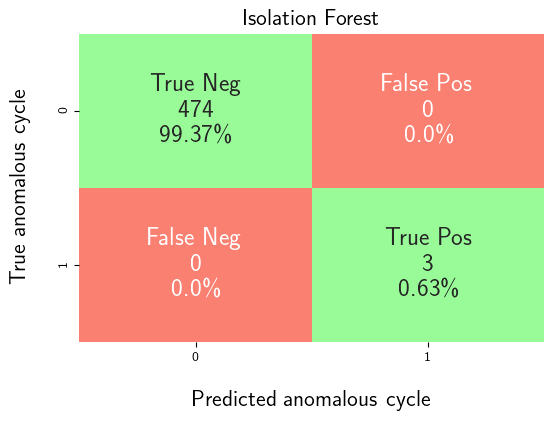

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
MCC-score: 1.0
****************************************************************************************************
Have the metrics for iforest on cell cell_num_1 been evaluated before?
True
----------------------------------------------------------------------
Replacing existing row for iforest, cell_num_1.
Metrics for iforest, cell_num_1 have been replaced in the CSV file.


,ml_model,cell_index,accuracy,precision,recall,f1_score,mcc_score
0,iforest,cell_num_1,1.0,1.0,1.0,1.0,1.0


In [10]:
df_eval_outlier = modval.evaluate_pred_outliers(
    df_benchmark=df_selected_cell,
    outlier_cycle_index=pred_outlier_indices)

# Confusion matrix
axplot = modval.generate_confusion_matrix(
    y_true=df_eval_outlier["true_outlier"],
    y_pred=df_eval_outlier["pred_outlier"])

axplot.set_title(
    "Isolation Forest",
    fontsize=16)

output_fig_filename = (
    "conf_matrix_iforest_"
    + selected_cell_label
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

# Evaluate model performance
df_current_eval_metrics = modval.eval_model_performance(
    model_name="iforest",
    selected_cell_label=selected_cell_label,
    df_eval_outliers=df_eval_outlier)

# Export model performance metrics to CSV output
hyperparam_eval_filepath =  Path.cwd().joinpath(
    "eval_metrics_hp_single_cell_tohoku.csv")

hp.export_current_model_metrics(
    model_name="iforest",
    selected_cell_label=selected_cell_label,
    df_current_eval_metrics=df_current_eval_metrics,
    export_csv_filepath=hyperparam_eval_filepath,
    if_exists="replace")

# Step-10: Visualize Predicted Anomalies

* Plot the capacity fade curve with predicted anomalies highlighted.
* Annotate the anomalous cycle indices on the plot.
* This visualization helps interpret where the model detected sudden capacity
  drops, which may indicate battery degradation events.

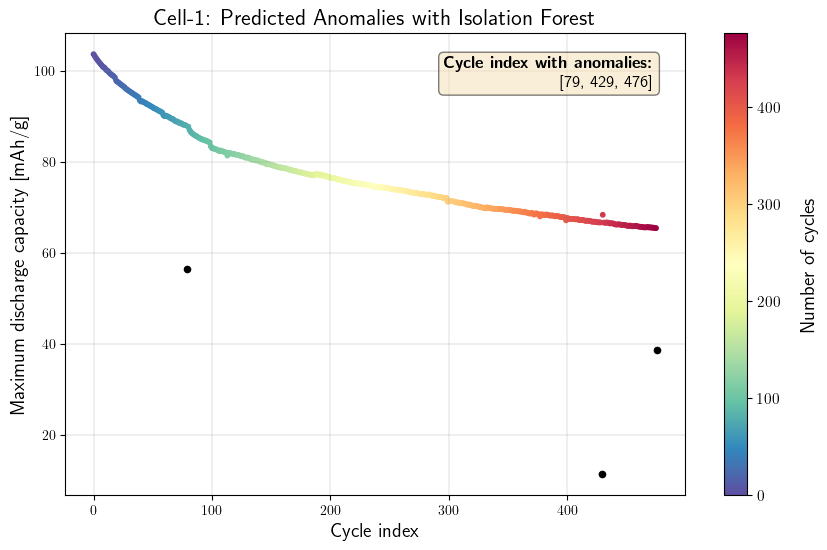

In [11]:
# Reset the sns settings
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams["text.usetex"] = True

pred_cap_outlier = max_cap_per_cycle[
    max_cap_per_cycle
        .index.isin(pred_outlier_indices)]

axplot = bviz.plot_cycle_data(
    xseries=unique_cycle_index,
    yseries=max_cap_per_cycle,
    cycle_index_series=unique_cycle_index,
    xoutlier=pred_cap_outlier.index,
    youtlier=pred_cap_outlier)

axplot.set_xlabel(
    r"Cycle index",
    fontsize=14)
axplot.set_ylabel(
    r"Maximum discharge capacity [mAh/g]",
    fontsize=14)

axplot.set_title(
    f"Cell-{cell_num}: Predicted Anomalies with Isolation Forest",
    fontsize=16)

# Create textbox to annotate anomalous cycle
textstr = '\n'.join((
    r"\textbf{Cycle index with anomalies:}",
    f"{list(pred_cap_outlier.index)}"))

# properties for bbox
props = dict(
    boxstyle='round',
    facecolor='wheat',
    alpha=0.5)

# first 0.95 corresponds to the left right alignment starting
# from left, second 0.95 corresponds to up down alignment
# starting from bottom
axplot.text(
    0.95, 0.95,
    textstr,
    transform=axplot.transAxes,
    fontsize=12,
    # ha means right alignment of the text
    ha="right", va='top',
    bbox=props)

output_fig_filename = (
    "iforest_pred_cap_fade_with_outliers_"
    + selected_cell_label
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()